# Active Subspace Analysis on a Single Diode PV model

##### Ryan Howard, CO School of Mines, <ryhoward@mines.edu>
##### Paul Constantine, CO School of Mines, <pconstan@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces methodology and results on a single-diode solar cell model presented in [[1]][R1].

### Introduction

Scientific and engineering models will usually contain input parameters (physical constants, geometric specifications, etc.), and important questions about the model's output often require characterizing the relationship between the output and the input parameters. Intuition about the physical system can become unreliable as models grow in complexity and the required number of model evaluations for parameter studies grows exponentially with increasing dimension. One solution to these issues is dimension reduction: using low-dimensional structure to perform parameter studies.

### Active Subspaces

_Active Subspaces_ is a method of dimension reduction that identifies important directions in the input space, along which perturbations in inputs change the output more than in the orthogonal directions. We consider the model's the output, $f$, as a function of the normalized input parameters, $\mathbf x$: $f = f(\mathbf x)$. The active subspaces methodology is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T \rho(\mathbf x)\ d\mathbf x = \mathbf W \Lambda\mathbf W^T
$$

where $\rho$ is a probability density on $\mathbf x$ and $\mathbf W \Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ (the diagonal of $\Lambda$ contains the eigenvalues of $\mathbf C$ in descending order, and $\mathbf W$'s columns contain the corresponding eigenvectors). We can partition the decomposition:

$$
\mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],\ \Lambda = \left[\begin{matrix} \Lambda_1 & \\ & \Lambda_2\end{matrix}\right]
$$

where $\mathbf W_1$ contains the first $n$ eigenvectors and $\Lambda_1$ contains the first $n$ eigenvalues. The active subspace is the space spanned by $\mathbf W_1$ and the active variables are $\mathbf y = \mathbf W_1^T\mathbf x$. The amount $f$ tends to change along the direction defined by the eigenvector $w_i$ is $\int(\nabla f^Tw_i)^2\rho d\mathbf x = \lambda_i$, and the amount $f$ tends to change along the active subspace is $\int(\nabla_yf)^T(\nabla_yf)\rho d\mathbf x = \lambda_1 + \cdots + \lambda_n$. If an eigenvalue were exactly zero, $f$ would be exactly constant along the corresponding eigenvector; in practice, the first several eigenvalues will be much larger than the later values (though they are nonzero), so $f$ could be reasonably examined in this low dimensional subspace.

To identify an active subspace, we approximate $\mathbf C$ with simple Monte Carlo: draw $\{\mathbf x_i\}_{i=1}^M$ from $\rho$, then

$$
\mathbf C\approx\mathbf{\hat C} = \frac 1 M\sum_{i=1}^M \nabla f(\mathbf x_i)\nabla f(\mathbf x_i)^T = \mathbf{\hat W}\hat\Lambda\mathbf{\hat W}^T
$$

The distance between $\mathbf W_1$ and $\mathbf{\hat W}_1$ is inversely proportional to $\lambda_{n+1}-\lambda_n$, so large gaps in eigenvalue magnitudes are what we use to identify the active subspace. We can use a bootstrap procedure to estimate the variability in the eigenvalues/vectors: for $j$ from 1 to $N$, let $\pi^j$ be an $M$-vector of integers sampled uniformly between 1 and $M$. The $j^{th}$ bootstrap replicate of $\mathbf{\hat C}$ is 

$$
\mathbf{\hat C}^j = \frac 1 M\sum_{i=1}^M\nabla f(\mathbf x_{\pi_i^j})\nabla f(\mathbf x_{\pi_i^j})^T = \mathbf{\hat W}^j\hat\Lambda^j(\mathbf{\hat W}^j)^T
$$

When the gradient of $f$ is not known analytically, it must be approximated; we use first order finite differences in the case of our solar cell model. Important to note is that our solar cell model does not take long to run, even on home PC's. If we had a model that was very expensive, taking hours to run on HPC platforms, strategies for choosing model evaluation points and approximating gradients would have to be altered to fit within the limited computational budget.

### The solar cell model

We use active subspaces to analyze a single-diode solar cell model that well describes the current-voltage (I-V) relationship of many series-wired photovoltaic (PV) devices. The equation governing I and V is

$$
I = I_L - I_s\left(\exp\left(\frac{V+IR_S}{N_SnV_{th}}\right) - 1\right) - \frac{V+IR_S}{R_P}
$$

where

$$
I_L = I_{SC}+I_S\left(\exp\left(\frac{I_{SC}R_S}{N_SnV_{th}}\right)-1\right)+\frac{I_{SC}R_S}{R_P}
$$

$N_S$ is the number of series-connected cells (we set this to 1) and $V_{th}$ is a fixed thermal voltage for temperature $T = 25^o$C. The rest of the parameters are input parameters of the model, and their ranges and densities are summarized in the table below.

Variable | Lower bound | Upper bound | Density
--- | --- | --- | ---
Short-circuit current, $I_{SC}$ | 0.05989 | 0.23958 | Uniform
Diode reverse saturation current, $I_S$ | 2.2e-11 | 2.2e-7 | Log-uniform
Ideality factor, $n$ | 1 | 2 | Uniform
Series resistance, $R_S$ | 0.16625 | 0.66500 | Uniform
Parallel (shunt) resistance, $R_P$ | 93.75 | 375 | Uniform

The quantity of interest we want to examine is the maximum power output of the cell: $P_{max} = \max\limits_{I,V}\ IV$, where I and V are constrained by the equations presented above.

### References:

[[1]][R1] Discovering an active subspace in a single-diode solar cell model, _Statistical Analysis and Data Mining: The ASA Data Science Journal_

[[2]][R2] Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces, _SIAM Journal of Scientific Computing_

[R1]: http://dx.doi.org/10.1002/sam.11281
[R2]: http://dx.doi.org/10.1137/130916138

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces)

In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
%matplotlib inline

Import the data set, which contains 10,000 sets of input parameters and corresponding $P_{max}$ values with gradients computed using finite differences. Distinguish inputs (X), outputs (F), and gradients (G).

In [2]:
df = pn.DataFrame.from_csv('SingleDiodePV-Pmax.txt')
data = df.as_matrix()
X = data[:,:5]
F = data[:,5]
G = data[:,6:]
M,m = X.shape
labels = df.keys()
in_labels = labels[:5]
out_label = labels[5]

Normalize the inputs to the interval [-1,1]. The second variable is uniform in the log space.

In [3]:
xl = np.array([0.05989, -24.539978662570231, 1.0, 0.16625, 93.75])
xu = np.array([0.23598, -15.3296382905940, 2.0, 0.665, 375.0])
Y = X.copy()
Y[:,1] = np.log(Y[:,1])
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(Y)

Set 'f' to be the output of interest.

In [4]:
f = F.copy()

Compute the active subspace.

In [5]:
ss = ac.subspaces.Subspaces()
ss.compute(df=G, nboot=500)

Bootstrap for eigenvector components.

In [6]:
N = int(1e4) #Number of bootstrap replicates
w1_boot = np.empty(shape=(m, N)) #matrix containing replicates of W1
w2_boot = np.empty(shape=(m, N)) #matrix containing replicates of W2
ssboot = ac.subspaces.Subspaces() #Subspaces object for computing W

for k in range(N):
    mask = np.random.randint(0, M, size=(M,))
    dfboot = G[mask,:]
    ssboot.compute(df=dfboot)
    w1_boot[:,k] = ssboot.eigenvectors[:,0]
    w2_boot[:,k] = ssboot.eigenvectors[:,1]
    
w1_br = np.empty(shape=(m, 2)) #min-to-max range of bootstrap values
w2_br = np.empty(shape=(m, 2)) 
w1_br[:,0] = np.squeeze(np.apply_over_axes(np.amin, w1_boot, axes=(1)))
w1_br[:,1] = np.squeeze(np.apply_over_axes(np.amax, w1_boot, axes=(1)))
w2_br[:,0] = np.squeeze(np.apply_over_axes(np.amin, w2_boot, axes=(1)))
w2_br[:,1] = np.squeeze(np.apply_over_axes(np.amax, w2_boot, axes=(1)))
w_br = np.hstack((w1_br, w2_br))

Plot eigenvalues, subspace errors, and eigenvectors, all with bootstrapped ranges (see also Figures 2 and 3 of [[1]][R1]).
[R1]: http://dx.doi.org/10.1002/sam.11281

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


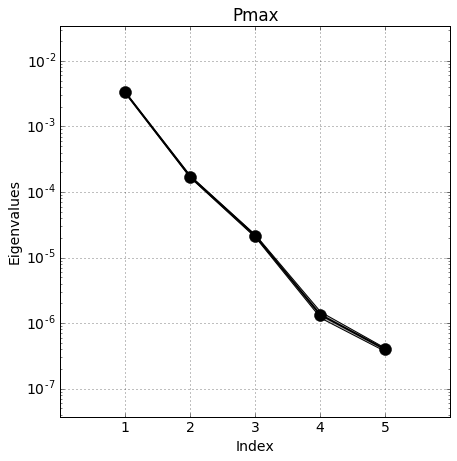

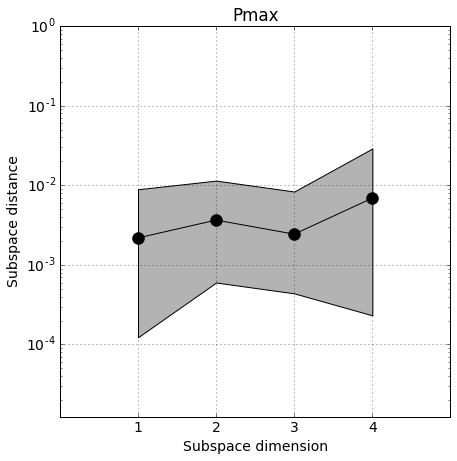

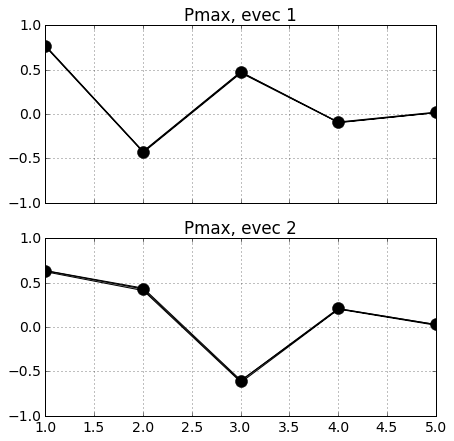

In [7]:
ac.utils.plotters.eigenvalues(ss.eigenvalues, e_br=ss.e_br, out_label=out_label)
ac.utils.plotters.subspace_errors(ss.sub_br, out_label=out_label)
ac.utils.plotters.eigenvectors(ss.eigenvectors[:,:2], W_br=w_br, out_label=out_label)

We can see a large (order of magnitude) difference between the first and second eigenvalues; this indicates that there could be a 1-dimensional active subspace. Because we have so much data, the bootstrapped ranges for eigenvalues and eigenvectors are very tight, nearly indistinguishable from the measured values; if we had less data, the ranges would be wider. 

<br>

Plot the quantity of interest, $P_{max}$, against the active variables ($\mathbf W_1^T\mathbf x$), for one and two-dimensional subspaces (see also Figure 4 of [[1]][R1]).
[R1]: http://dx.doi.org/10.1002/sam.11281

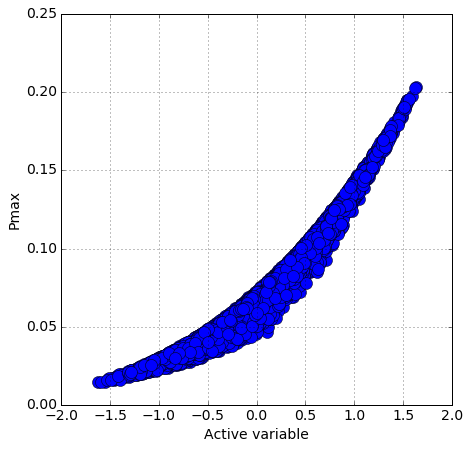

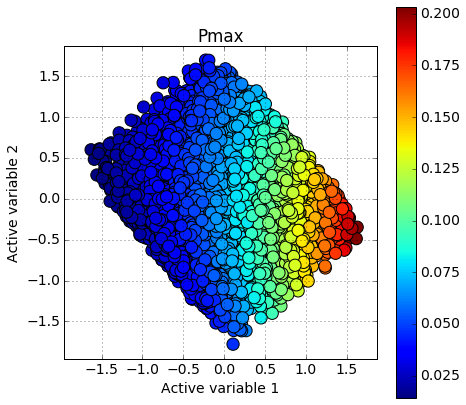

In [8]:
ss.partition(2)
y = np.dot(XX,ss.W1)
ac.utils.plotters.sufficient_summary(y,f,out_label=out_label)

We can see a fairly tight univariate trend in the first graph of $P_{max}$ vs. the first active variable, and $P_{max}$ in the 2-d plot varies primarily along the axis of the first active variable. These facts indicate we have a one-dimensional active subspace that can be exploited for parameter studies.

<br>

We'll now examine the components of the first eigenvector, $w_1$, that defines the direction of our active subspace.

In [9]:
ss.partition(1)
#display the eigenvector components and the corresponding input variables
for k in range(m):
    print "The variable {:5} has eigenvector component {:10.4}".format(in_labels[k], ss.W1[k,0])

The variable ISC   has eigenvector component     0.7674
The variable IS    has eigenvector component    -0.4228
The variable n     has eigenvector component      0.473
The variable RS    has eigenvector component   -0.09064
The variable RP    has eigenvector component     0.0207


A component with a large magnitude indicates the output is relatively sensitive to changes in the corresponding variable. Since $R_S$ and $R_P$ have components close to 0, they tend not to affect output much compared to $I_{SC}$, $I_S$, and $n$. The high weight on $I_{SC}$ can be explained by the physics of the system; for the maximizer of power, $(I_{max}, V_{max})$, $I_{max}$ scales linearly with $I_{SC}$ and $V_{max}$ scales logarithmically, so their product sales like a product of a linear term and a logarithmic term. The dependence of both $I_{max}$ and $V_{max}$ on $I_{SC}$ explains its importance in the active subspace. It is also possible that the chosen parameter ranges have made $R_S$ and $R_P$ appear unimportant; the ranges for these variables used in the simulation are smaller than what would be observed in practice while the other ranges are representative of reality. Widening the ranges of $R_S$ and $R_P$ could increase their importance in the active subspace.

When computing first-order and total sensitivity Sobol' indices on this system (see Table 2 of [[1]][R1]), we find that these metrics also rank $I_{SC}$, $I_S$, and $n$ as important and $R_S$ and $R_P$ as unimportant. Despite the similar conclusions regarding individual variables, the application of the two methods is different. From the Sobol' indices, one might set $R_S$ and $R_P$ at nominal values and perform parameter studies using only the other 3 parameters, resulting in overall dimension reduction of 5D to 3D, while the active subspace exploits a _single_ direction in the input space that takes the dimensionality all the way down to 1D.

[R1]: http://dx.doi.org/10.1002/sam.11281

### Using Active Subspaces

There are several ways in which one could use the 1-dimensional active subspace of this system to aid parameter studies. It aids in data visualization since it takes a 5-dimensional input space that is impossible to plot down to a 1 or 2-dimensional space for which plotting is easy. The 1-dimensional structure can be used in optimization problems that would be difficult to implement in 5 dimensions. The tightness of the data in the active subspace lends itself to constructing response surfaces to approximate the map from inputs to output. Computing an integration-based average of $P_{max}$ could be made much easier in the single active direction opposed to the full 5D input space. Lastly, the active subspace can be used to find ranges of input values that constrain the output to fall within a certain range.